In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import os
import re

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

/home/yizhou/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
from dataset import HandleDataset, get_train_transform, collate_fn

In [5]:
train_dataset = HandleDataset("/home/yizhou/Research/temp/", get_train_transform()) #

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [6]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [7]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


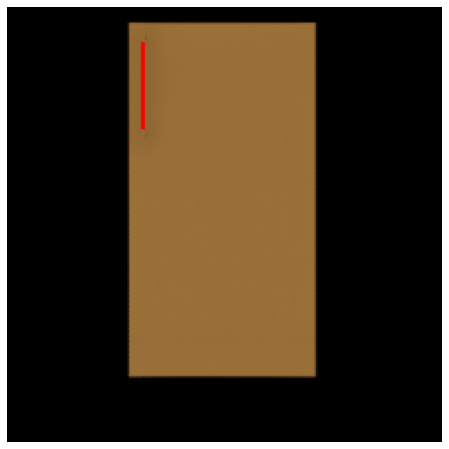

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [9]:
len(train_dataset)

174

# Model

In [10]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [11]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [ ]:
torch.stack(images).cuda()

In [ ]:
targets

In [ ]:
loss_dict = model(torch.stack(images).cuda(), targets)

In [ ]:
pause

In [ ]:
for i, (images, targets, image_ids) in enumerate(train_data_loader): 
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    print(i, image_ids)
    # print(len(images))

In [ ]:
pause

In [ ]:
# images, boxes = torch.rand(2, 3, 224, 224), torch.rand(2, 1, 4)

In [13]:
boxes = torch.rand(2, 1, 4) * 224

In [14]:
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]

In [15]:
labels = torch.randint(0, 1, (4, 1)) + 1

In [16]:
labels

tensor([[1],
        [1],
        [1],
        [1]])

In [17]:
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

In [18]:
targets

[{'boxes': tensor([[151.6770, 105.1310, 321.0735, 239.0103]]),
  'labels': tensor([1])},
 {'boxes': tensor([[146.8885,  77.4219, 292.3548, 197.1121]]),
  'labels': tensor([1])}]

In [19]:
model = model.cpu()

In [ ]:
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
targets

In [20]:
output = model(torch.stack(images).to("cpu"), targets)

In [21]:
output

{'loss_classifier': tensor(0.5638, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(6.1270e-05, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0303, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0015, grad_fn=<DivBackward0>)}

# Train

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
images

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   